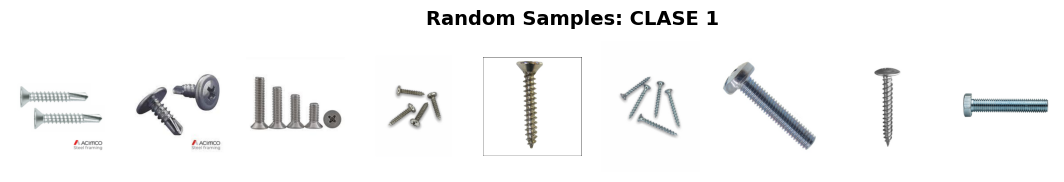

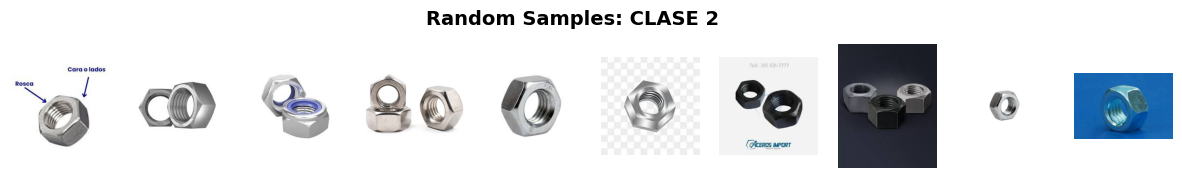

In [2]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
if not os.path.exists('Dataset.zip'):
    !wget https://raw.githubusercontent.com/MateoOnate27/Computational-Vision-Laboratories-/main/Dataset.zip
    !unzip -q Dataset.zip
    print("Dataset descargado y listo.")

PATH_DATASET = 'Dataset'
CLASES = ['clase 1', 'clase 2']
CLASES = ['clase 1', 'clase 2']

K1_IDENTITY = np.array([[0,0,0],[0,1,0],[0,0,0]])
K2_LAPLACIAN = np.array([[0,1,0],[1,-4,1],[0,1,0]])

def cargar_rutas():
    rutas_dict = {clase: [] for clase in CLASES}
    for clase in CLASES:
        folder = os.path.join(PATH_DATASET, clase)
        if os.path.exists(folder):
            rutas_dict[clase] = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
    return rutas_dict

rutas = cargar_rutas()

for clase in CLASES:
    plt.figure(figsize=(15, 2))
    plt.suptitle(f"Random Samples: {clase.upper()}", fontsize=14, fontweight='bold')
    seleccion = random.sample(rutas[clase], min(10, len(rutas[clase])))
    for i, r in enumerate(seleccion):
        img_plt = cv2.cvtColor(cv2.imread(r), cv2.COLOR_BGR2RGB)
        plt.subplot(1, 10, i + 1)
        plt.imshow(img_plt)
        plt.axis('off')
    plt.show()

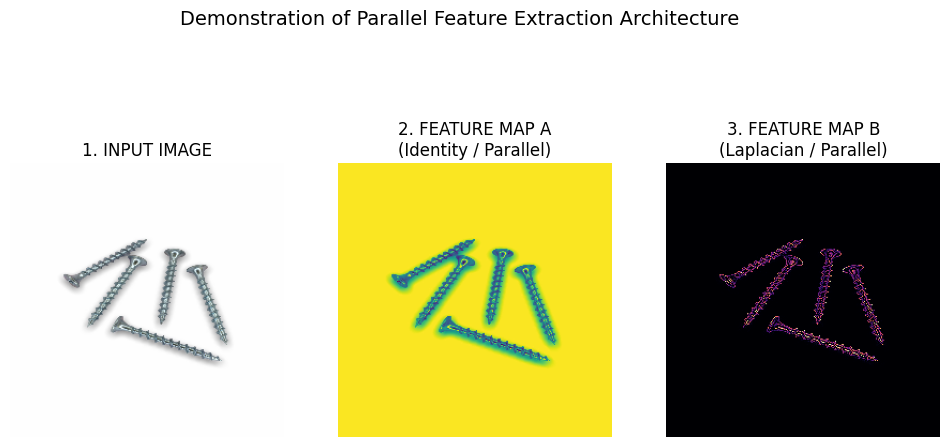

In [3]:
def extract_features(path):
    img = cv2.imread(path)
    if img is None: return None
    img = cv2.resize(img, (256, 256))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    f_map_1 = cv2.filter2D(gray, -1, K1_IDENTITY)
    f_map_2 = cv2.filter2D(gray, -1, K2_LAPLACIAN)

    # FILTRO 1: Fotometría (desde Rama A)
    intensity_val = np.mean(f_map_1)

    # FILTRO 2: Geometría / Elongación (desde Rama B y segmentación)
    blur = cv2.GaussianBlur(f_map_1, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        rect = cv2.minAreaRect(c)
        (x, y), (w, h), ang = rect
        elongation = max(w, h) / min(w, h) if min(w, h) > 0 else 1
    else:
        elongation = 1

    return [intensity_val, elongation], img, f_map_1, f_map_2, thresh

sample_path = rutas['clase 1'][0]
data = extract_features(sample_path)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(data[1], cv2.COLOR_BGR2RGB))
plt.title("1. INPUT IMAGE")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(data[2], cmap='viridis')
plt.title("2. FEATURE MAP A\n(Identity / Parallel)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(data[3], cmap='magma')
plt.title("3. FEATURE MAP B\n(Laplacian / Parallel)")
plt.axis('off')
plt.suptitle("Demonstration of Parallel Feature Extraction Architecture", fontsize=14)
plt.show()


FINAL ACCURACY: 78.95%



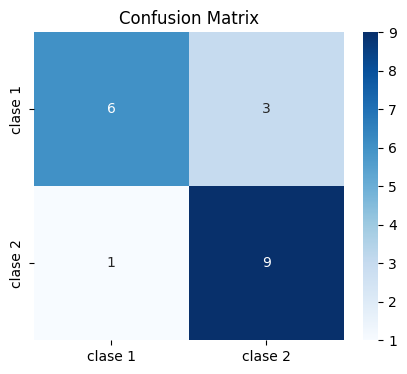

In [4]:
X, y = np.array(X), np.array(y)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

p1 = np.mean(X_norm[y == 0], axis=0)
p2 = np.mean(X_norm[y == 1], axis=0)
preds = np.array([0 if np.linalg.norm(f - p1) < np.linalg.norm(f - p2) else 1 for f in X_norm])

acc = accuracy_score(y, preds) * 100
print(f"\n" + "="*30)
print(f"FINAL ACCURACY: {acc:.2f}%")
print("="*30 + "\n")

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y, preds), annot=True, cmap='Blues', xticklabels=CLASES, yticklabels=CLASES)
plt.title("Confusion Matrix")
plt.show()

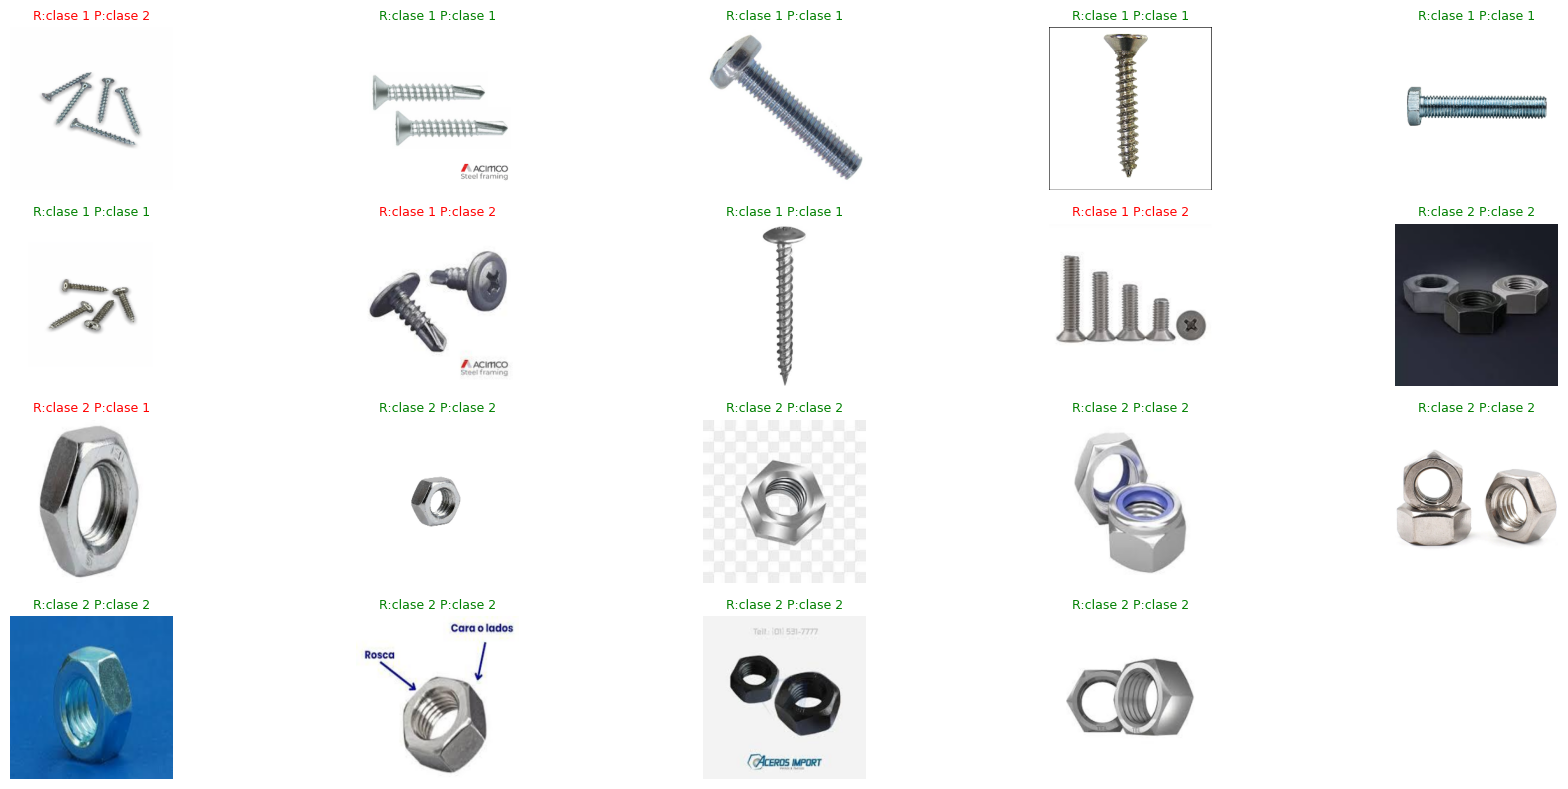

In [5]:
plt.figure(figsize=(18, 8))
for i in range(len(y)):
    plt.subplot(4, 5, i + 1)
    img_rgb = cv2.cvtColor(images_orig[i], cv2.COLOR_BGR2RGB)
    color = 'green' if y[i] == preds[i] else 'red'
    plt.imshow(img_rgb)
    plt.title(f"R:{CLASES[y[i]]} P:{CLASES[preds[i]]}", color=color, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()